# Putting it all together

So far, we have cleaned and extracted our relevant news data, ticker data, and have researched our target variable, which in this case is higher than average volatility and volume. Our goal is to combine the model that uses text data with the model that uses tick data. The problem with attempting to do this in a single Keras model is that each data set has very different make up and timeframes. The text data only goes back to 2017, but has up to hundreds of news articles on a given day. The tick data goes back to 2013, but only has single entries per trading day. 

We hypothesize that both morning tick data and news data will be useful in predicting whether or not a given ETF will have higher than average volatility and volume. Therefore, we will fit models independently using a deep learning RNN framework (this is to capture the temporal nature of the data) and unite the probability predictions using a random forest model. This seems very complex, perhaps even overly so, but considering how difficult it is to predict anything to do with financial markets, we want to throw as much compute power at this problem as possible! Furthermore, deep learning is a framework that is beginning to but has not yet fully become integrated in trading, so this project hopes to analyze the success of this particular use case of the greatest algorithmic advancement of the 21st century (in terms of ease of use and computer power: Neural nets were first invented in the 1950s).

In [1]:
# Load packages
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import datetime
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Embedding, Conv2D
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model, clone_model
from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.optimizers import SGD
from keras import backend as K
from sklearn.utils import class_weight
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
np.random.seed(0)

api = tradeapi.REST(
    base_url=os.environ['APCA_API_BASE_URL'],
    key_id=os.environ['APCA_API_KEY_ID'],
    secret_key=os.environ['APCA_API_SECRET_KEY']
)

Using TensorFlow backend.


We will use a class based model in order to capture all of the various moving parts. By saving each independent model, we can easily access them later in case we need to use them. The ultimate goal here is to fit models at the end of each trading week, compare the performance of the old versus the new model, and keep the one which performs best. This CombinedModel class will not only be able to fit new models, but will be able to evaluate the performance of each model independently.

In [2]:
class CombinedModel():

    def __init__(self, target='data/vv_target.csv'):
        """ Initializes by getting each dataset. """
        # Load each csv
        self.text = pd.read_csv('data/tokenized_text.csv', index_col=0)
        self.tick = pd.read_csv('data/wrapped_tick_data.csv', index_col=0)
        self.target= pd.read_csv(target, index_col=0)
        
        # Get models
        self.example_models = self.get_example_models()
        self.models = {'text': [], 'tick': []}
        
        # Get X, y train test split
        self.datasets = {}
        self.datasets['text'] = self.get_X_y(self.text, self.target)
        self.datasets['tick'] = self.get_X_y(self.tick, self.target)
        
        # Symbols
        self.symbols = [
            'DBC',
            'EEM',
            'EWJ',
            'FXI',
            'GDX',
            'GLD',
            'QQQ',
            'SPY',
            'TLT',
            'USO',
            'VTI',
            'VXX',
            'XHB',
            'XLF',
            'XRT',
            'XSW'
        ]

    def get_X_y(self, X, y, cutoff='2019-05-20'):
        """ Gets X and y based on join. Drops NA values. """
        total_df = X.join(y, how='left', lsuffix='l', rsuffix='r').dropna()
        symbols = list(y.columns)
        X, y = total_df[[c for c in total_df.columns if c not in symbols]], total_df[symbols]
        X_train, X_test = X.loc[:cutoff], X.loc[cutoff:]
        y_train, y_test = y.loc[:cutoff], y.loc[cutoff:]
        # Convert to binary
        y_train = y_train.astype('int64')
        y_test = y_test.astype('int64')
        return X_train, X_test, y_train, y_test
        
    def get_example_models(self):
        """ Gets text and ticker models according to appropriate parameters"""
        # Save models
        models = {}
        
        # Text Model
        embedding_size = 200
        input_ = Input(shape=(100,))
        x = Embedding(20000, embedding_size)(input_)
        x = CuDNNLSTM(50, return_sequences=True)(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.5)(x)
        x = Dense(200, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(16, activation='sigmoid')(x)
        model = Model(inputs=input_, outputs=x)
        # Choose Multilabel
        model.compile(loss='binary_crossentropy',
                      optimizer='adam', 
                      metrics=['accuracy'])
        models['text'] = model

        # Ticker Model
        input_ = Input(shape=(121, 80))
        x = CuDNNLSTM(40, return_sequences=True)(input_)
        x = GlobalMaxPool1D()(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(50, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(16, activation='sigmoid')(x)
        model = Model(inputs=input_, outputs=x)
        # Choose Multilabel
        model.compile(loss='binary_crossentropy',
                      optimizer='adam', 
                      metrics=['accuracy'])
        models['tick'] = model

        return models

    def get_oof(self, clf, data, key, NFOLDS=10, epochs=1, batch_size=256):
        """ Get's out of fold predictions for a classifier. 
            Credit: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
            Slightly modified to handle sklearn 0.20.3
        """
        # Get train test split
        x_train, x_test, y_train, y_test = data[key]
        cols, train_idx, test_idx = (y_train.columns, 
                                     pd.to_datetime(y_train.index, utc=True).tz_convert('US/Eastern'), 
                                     pd.to_datetime(y_test.index, utc=True).tz_convert('US/Eastern') 
                                    )

        # Get values for KFold compatibility
        y_train = y_train.values
        y_test = y_test.values
        if key == 'tick':
            x_train = x_train.values.reshape(x_train.shape[0], 121, 80)
            x_test = x_test.values.reshape(x_test.shape[0], 121, 80)
        else:
            x_train = x_train.values
            x_test = x_test.values

        # Some useful parameters which will come in handy later on
        ntrain_x, ntrain_y = x_train.shape[0], y_train.shape[1]
        ntest_x, ntest_y = x_test.shape[0], y_test.shape[1]
        SEED = 0 # for reproducibility
        kf = KFold(n_splits=NFOLDS, random_state=SEED)
        oof_train = np.zeros((ntrain_x, ntrain_y))
        oof_test = np.zeros((ntest_x, ntest_y))
        oof_test_skf = np.empty((NFOLDS, ntest_x, ntest_y))
        
        for i, (train_index, test_index) in enumerate(kf.split(x_train)):
            print(f"Fitting Fold {i}")
            x_tr = x_train[train_index]
            y_tr = y_train[train_index]
            x_te = x_train[test_index]
            y_te = y_train[test_index]

            # Recompile to start from scratch
            curr_clf = clone_model(clf)
            np.random.seed(0)
            curr_clf.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
            earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
            curr_clf.fit(x_tr, y_tr, epochs=epochs, batch_size=batch_size, validation_data=(x_te, y_te),
                         callbacks=[earlyStopping])
            self.models[key].append(curr_clf)

            # Use predict and get confidence of model predicting 1 = 'Yes'
            oof_train[test_index, :] = curr_clf.predict(x_te) 
            # For test set, we use each of the 5 folds
            oof_test_skf[i, :] = curr_clf.predict(x_test)

        # and average predictions
        oof_test[:] = oof_test_skf.mean(axis=0)
        oof_train = pd.DataFrame(oof_train, columns=cols, index=train_idx).groupby(pd.Grouper(freq='D')).mean().dropna()
        oof_test = pd.DataFrame(oof_test, columns=cols, index=test_idx).groupby(pd.Grouper(freq='D')).mean().dropna()
        return oof_train, oof_test


    def build_pred_data(self):
        """ Get's oof predictions for every classifier in a dictionary of models. """
        X_train_f, X_test_f = {}, {}
        clf_dict = self.example_models
        data = self.datasets
        # Columns will be model predictions 
        # labeled according to model
        for key, clf in clf_dict.items():
            if key == "tick":
                X_train_f[key], X_test_f[key] = self.get_oof(clf, data, key, epochs=15, batch_size=16)
            else:
                X_train_f[key], X_test_f[key] = self.get_oof(clf, data, key)

        # Lastly, MinMax Scale to avoid bias
        pipe = make_pipeline(
            Imputer(),
            #MinMaxScaler()
        )
        X_train_f = X_train_f['text'].join(X_train_f['tick'], how='left', lsuffix='text', rsuffix='tick')
        X_test_f = X_test_f['text'].join(X_test_f['tick'], how='left', lsuffix='text', rsuffix='tick')
        
        # Convert to DataFrames
        self.target.index = pd.to_datetime(self.target.index, utc=True).tz_convert('US/Eastern') 
        X_train_f = pd.DataFrame(pipe.fit_transform(X_train_f), columns=X_train_f.columns, index=X_train_f.index).drop_duplicates()
        y_train = self.target.join(X_train_f, how='right')[self.target.columns]
        X_test_f = pd.DataFrame(pipe.transform(X_test_f), columns=X_test_f.columns, index=X_test_f.index).drop_duplicates()
        y_test = self.target.join(X_test_f, how='right')[self.target.columns]
        self.datasets['final'] = [X_train_f, X_test_f, y_train, y_test]
        return X_train_f, X_test_f, y_train, y_test
    
    def model_search(self):
        """ Stacks text and tick data deep learning predictions. 
            Conducts random grid search to optimize parameters for stacked random forest. """
        if 'final' not in self.datasets:
            X_train, X_test, y_train, y_test = self.build_pred_data()
        else:
            X_train, X_test, y_train, y_test = self.datasets['final']
        param_grid = {
            'clf__bootstrap': [True],
            'clf__max_depth': range(2, 6),
            'clf__max_features': range(2, 6),
            'clf__min_samples_leaf': range(3, 7),
            'clf__min_samples_split': range(6, 14),
            'clf__n_estimators': range(6, 14)
        }
        
        # Store each model
        models = {}
        # each out of sample training prediction
        y_train_df = {}
        # each test prediction
        y_test_df = {}
        
        for symbol in self.symbols:
            # Create a base model
            clf = RandomForestClassifier()
            steps = [('scaler', StandardScaler()), ('clf', clf)]
            pipe = Pipeline(steps)
            # Instantiate the grid search model
            grid_search = RandomizedSearchCV(estimator=pipe, n_iter=50, param_distributions=param_grid, 
                                             cv=10, n_jobs=4, verbose=2, scoring='accuracy')
            # Upsample to have even distribution
            resample = SMOTE()
            X_train_r, y_train_r = resample.fit_resample(X_train, y_train[symbol])
            grid_search.fit(X_train_r, y_train_r)
            
            # Get train and test predictions
            y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train[symbol], cv=10)
            y_train_df[symbol] = pd.DataFrame(y_train_pred, index=y_train.index, columns=[symbol])
            y_test_pred = grid_search.predict(X_test)
            y_test_df[symbol] = pd.DataFrame(y_test_pred, index=y_test.index, columns=[symbol])
            
            # Print statistics
            print(f'Metrics for {symbol}')
            print('CV Score ', cross_val_score(grid_search.best_estimator_, X_train, y_train[symbol], cv=10).mean())
            print('Test score ', accuracy_score(y_test[symbol], y_test_pred))
            models[symbol] = grid_search.best_estimator_
        self.models['combined'] = models
        y_train_df = pd.concat(y_train_df.values(), axis=1)
        y_test_df = pd.concat(y_test_df.values(), axis=1)
        return y_train_df, y_test_df, models

First we will instantiate a CombinedModel instance. This will load our necessary csv files and prepare the parameters that we will need for later storage.

In [3]:
model = CombinedModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


build_pred_data generates out-of-fold predictions for each entry in our text and tick data. By doing this, we avoid leakage into our final combined model. Although we suffer a little bit of lookahead bias (i.e., certain folds are fit on future data), we can assume that our model trades a small enough time horizon that we treat each day as mostly independent.

In [4]:
X_train, X_test, y_train, y_test = model.build_pred_data()

Fitting Fold 0
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 520570 samples, validate on 57842 samples
Epoch 1/1
520570/520570 [==============================] - 40s 77us/step - loss: 0.5741 - acc: 0.6919 - val_loss: 0.6958 - val_acc: 0.5983
Fitting Fold 1
Train on 520570 samples, validate on 57842 samples
Epoch 1/1
520570/520570 [==============================] - 33s 63us/step - loss: 0.5847 - acc: 0.6793 - val_loss: 0.6151 - val_acc: 0.6777
Fitting Fold 2
Train on 520571 samples, validate on 57841 samples
Epoch 1/1
520571/520571 [==============================] - 33s 64us/step - loss: 0.5779 - acc: 0.6897 - val_loss: 0.6603 - val_acc: 0.6259
Fitting Fold 3
Train on 520571 samples, validate on 57841 samples
Epoch 1/1
520571/520571 [==============================] - 34s 64us/step - loss: 0.5725 - acc: 0.6960 - val_loss: 0.7279 - val_acc: 0.5655
Fitting Fold 4
Train on 520571 samples, validate on 57

1129/1129 [==============================] - 3s 3ms/step - loss: 0.6891 - acc: 0.5431 - val_loss: 0.7432 - val_acc: 0.4315
Epoch 2/15
1129/1129 [==============================] - 1s 794us/step - loss: 0.6790 - acc: 0.5747 - val_loss: 0.7321 - val_acc: 0.4405
Epoch 3/15
1129/1129 [==============================] - 1s 785us/step - loss: 0.6752 - acc: 0.5760 - val_loss: 0.7423 - val_acc: 0.4405
Epoch 4/15
1129/1129 [==============================] - 1s 765us/step - loss: 0.6741 - acc: 0.5747 - val_loss: 0.7577 - val_acc: 0.4296
Epoch 5/15
1129/1129 [==============================] - 1s 802us/step - loss: 0.6734 - acc: 0.5835 - val_loss: 0.7275 - val_acc: 0.4306
Epoch 6/15
1129/1129 [==============================] - 1s 771us/step - loss: 0.6695 - acc: 0.5834 - val_loss: 0.7366 - val_acc: 0.4425
Epoch 7/15
1129/1129 [==============================] - 1s 792us/step - loss: 0.6693 - acc: 0.5836 - val_loss: 0.7383 - val_acc: 0.4410
Epoch 8/15
1129/1129 [==============================] - 1s 78

Epoch 15/15
1130/1130 [==============================] - 1s 772us/step - loss: 0.6762 - acc: 0.5705 - val_loss: 0.6466 - val_acc: 0.6650
Fitting Fold 7
Train on 1130 samples, validate on 125 samples
Epoch 1/15
1130/1130 [==============================] - 3s 3ms/step - loss: 0.6925 - acc: 0.5357 - val_loss: 0.6491 - val_acc: 0.6805
Epoch 2/15
1130/1130 [==============================] - 1s 781us/step - loss: 0.6851 - acc: 0.5581 - val_loss: 0.6535 - val_acc: 0.6450
Epoch 3/15
1130/1130 [==============================] - 1s 787us/step - loss: 0.6828 - acc: 0.5570 - val_loss: 0.6419 - val_acc: 0.6675
Epoch 4/15
1130/1130 [==============================] - 1s 781us/step - loss: 0.6831 - acc: 0.5545 - val_loss: 0.6461 - val_acc: 0.6690
Epoch 5/15
1130/1130 [==============================] - 1s 785us/step - loss: 0.6811 - acc: 0.5597 - val_loss: 0.6391 - val_acc: 0.6730
Epoch 6/15
1130/1130 [==============================] - 1s 765us/step - loss: 0.6811 - acc: 0.5612 - val_loss: 0.6502 - val

C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
# Observe X_train
X_train.head()

,DBCtext,EEMtext,EWJtext,FXItext,GDXtext,GLDtext,QQQtext,SPYtext,TLTtext,USOtext,...,QQQtick,SPYtick,TLTtick,USOtick,VTItick,VXXtick,XHBtick,XLFtick,XRTtick,XSWtick
2017-12-08 00:00:00-05:00,0.489355,0.457717,0.568181,0.692604,0.207623,0.272464,0.858903,0.653818,0.229651,0.397161,...,0.442765,0.461158,0.456428,0.390141,0.423689,0.353370,0.420847,0.441292,0.371741,0.367808
2017-12-11 00:00:00-05:00,0.453744,0.373150,0.557593,0.604574,0.299511,0.313788,0.839292,0.619394,0.255917,0.415747,...,0.468832,0.504712,0.482897,0.453399,0.484300,0.413941,0.498694,0.461890,0.386721,0.444686
2017-12-14 00:00:00-05:00,0.603077,0.506183,0.736356,0.772341,0.377325,0.377379,0.959167,0.816836,0.320584,0.541130,...,0.442765,0.461158,0.456428,0.390141,0.423689,0.353370,0.420847,0.441292,0.371741,0.367808
2017-12-15 00:00:00-05:00,0.495824,0.473101,0.511445,0.719850,0.153746,0.240574,0.867138,0.632370,0.196865,0.373684,...,0.514328,0.571373,0.456038,0.394932,0.514171,0.331706,0.475057,0.511973,0.414182,0.511628
2017-12-21 00:00:00-05:00,0.460546,0.368720,0.558635,0.602132,0.305664,0.319122,0.841791,0.617557,0.255301,0.424460,...,0.496853,0.574711,0.529042,0.467833,0.535076,0.472002,0.514199,0.462283,0.436625,0.469371


Finally, we combine these model predictions using a random forest classifier. We optimize hyperparameters independently for each ETF.

In [6]:
y_train_df, y_test_df, models = model.model_search()

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.7s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for DBC
CV Score  0.5251949643493761
Test score  0.45454545454545453
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.9s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for EEM
CV Score  0.5097593582887701
Test score  0.6363636363636364
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for EWJ
CV Score  0.4865864527629234
Test score  0.45454545454545453
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for FXI
CV Score  0.4935828877005347
Test score  0.45454545454545453
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for GDX
CV Score  0.6763201871657755
Test score  0.2727272727272727
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for GLD
CV Score  0.5947916666666667
Test score  0.2727272727272727
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for QQQ
CV Score  0.7160539215686275
Test score  0.8181818181818182
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for SPY
CV Score  0.5548908199643494
Test score  0.6363636363636364
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for TLT
CV Score  0.5588465298142717
Test score  0.36363636363636365
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.2s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for USO
CV Score  0.4889540566959922
Test score  0.6363636363636364
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for VTI
CV Score  0.6058823529411764
Test score  0.6363636363636364
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 358 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.4s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for VXX
CV Score  0.9518438057040999
Test score  1.0
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for XHB
CV Score  0.368527183600713
Test score  0.5454545454545454
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.2s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for XLF
CV Score  0.6009191176470589
Test score  0.5454545454545454
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.0s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for XRT
CV Score  0.526437165775401
Test score  0.36363636363636365
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished
C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Metrics for XSW
CV Score  0.5984359726295211
Test score  0.7272727272727273


# Model Testing

We will examine the performance of on our test data and take a look at how much money our model would have made or lost per share invested.

In [7]:
# Test Accuracy
(y_test_df == y_test).sum().sum() / (y_test.shape[0] * y_test.shape[1])

0.5511363636363636

In [8]:
# Get strategy
rsi_df = pd.read_csv('data/rsi_pl.csv', index_col=0)
rsi_df.index = pd.to_datetime(rsi_df.index, utc=True).tz_convert('US/Eastern')

In [9]:
y_test_df

,DBC,EEM,EWJ,FXI,GDX,GLD,QQQ,SPY,TLT,USO,VTI,VXX,XHB,XLF,XRT,XSW
2019-05-20 00:00:00-04:00,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-21 00:00:00-04:00,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-22 00:00:00-04:00,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-23 00:00:00-04:00,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-24 00:00:00-04:00,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-28 00:00:00-04:00,1,0,1,1,1,0,1,1,0,1,1,0,1,1,1,1
2019-05-29 00:00:00-04:00,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
2019-05-30 00:00:00-04:00,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
2019-05-31 00:00:00-04:00,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1
2019-06-03 00:00:00-04:00,1,0,1,0,1,0,1,1,0,1,1,0,1,1,1,1


In [10]:
# Join test data
test_rsi = y_test_df.join(rsi_df, how='left', lsuffix='_l')[y_train.columns]

In [11]:
# If we had gotten it perfect
(test_rsi * y_test).sum().sum()

1.0698000000000913

In [12]:
# With our predictions
(test_rsi * y_test_df).sum().sum()

-0.07199999999995477

In [13]:
# Naive strategy
test_rsi.sum().sum()

1.173800000000167

# Overall Performance

Our CombinedModel generated out of fold predictions for each asset as well. Let's view our overall out of fold performance combined with 

In [14]:
# Get overall strategy predicted and ideal
train_rsi = y_train_df.join(rsi_df, how='left', lsuffix='_l')[y_train.columns]
overall_rsi_pred = pd.concat([train_rsi, test_rsi]) * pd.concat([y_train_df, y_test_df])
overall_rsi_ideal = pd.concat([train_rsi, test_rsi]) * pd.concat([y_train, y_test])

In [15]:
# Overall OOF Accuracy
(pd.concat([y_train_df, y_test_df]) == pd.concat([y_train, y_test])).sum().sum() / (pd.concat([y_train, y_test]).shape[0] * pd.concat([y_train, y_test]).shape[1])

0.5750368731563422

In [16]:
# If we had gotten it perfect
ideal = overall_rsi_ideal.sum().sum()
ideal 

64.9833000000006

In [17]:
# With our predictions
pred = overall_rsi_pred.sum().sum()
pred

60.20990000000015

In [18]:
# Naive strategy
naive = pd.concat([train_rsi, test_rsi]).sum().sum()
naive

18.667099999999024

In [19]:
tick = pd.read_csv('data/ticker_data.csv', index_col=0)
tick.index = pd.to_datetime(tick.index, utc=True).tz_convert('US/Eastern')

In [20]:
symbols = [
     'DBC',
     'EEM',
     'EWJ',
     'FXI',
     'GDX',
     'GLD',
     'QQQ',
     'SPY',
     'TLT',
     'USO',
     'VTI',
     'VXX',
     'XHB',
     'XLF',
     'XRT',
     'XSW'
]
start = tick[['close_' + s for s in symbols]].loc['2017-12-04 09:30:00-05:00'].sum()
diff = (tick[['close_' + s for s in symbols]].iloc[-1] - start)/start
start.index = symbols
diff.index = symbols

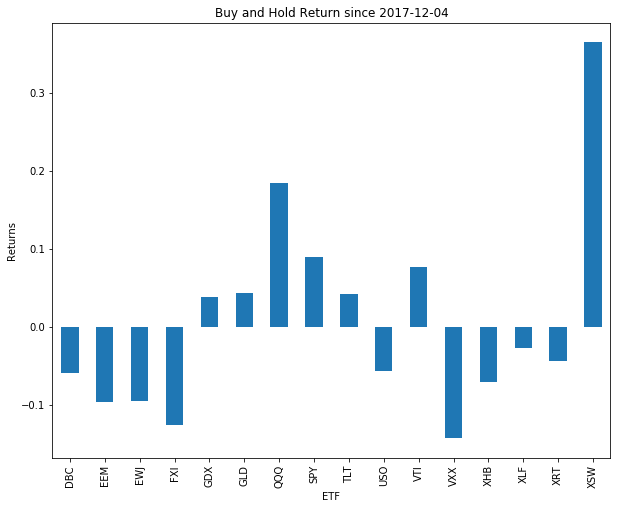

In [21]:
diff.plot(figsize=(10, 8), kind='bar')
plt.title('Buy and Hold Return since 2017-12-04')
plt.xlabel('ETF')
plt.ylabel('Returns')
plt.show()

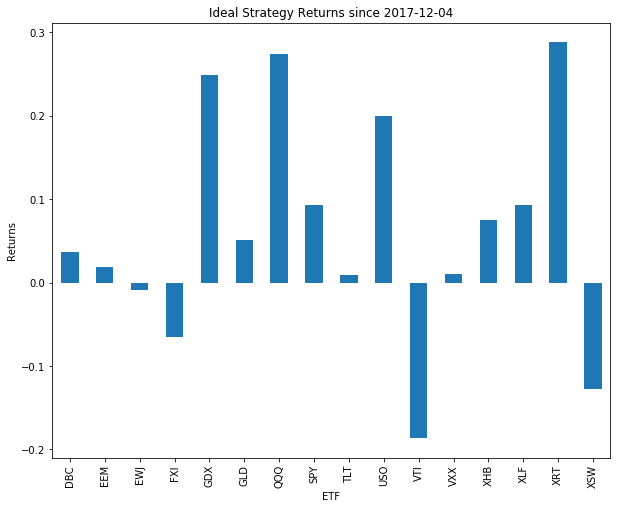

In [67]:
(overall_rsi_ideal.sum() / start).plot(figsize=(10, 8), kind='bar')
plt.title('Ideal Strategy Returns since 2017-12-04')
plt.xlabel('ETF')
plt.ylabel('Returns')
plt.show()

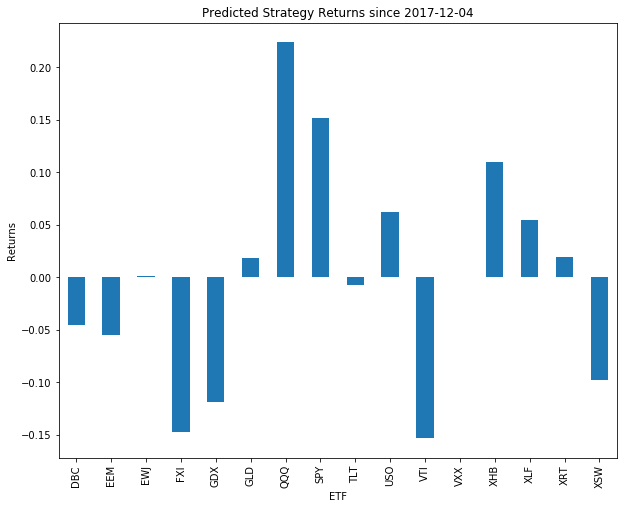

In [68]:
(overall_rsi_pred.sum() / start).plot(figsize=(10, 8), kind='bar')
plt.title('Predicted Strategy Returns since 2017-12-04')
plt.xlabel('ETF')
plt.ylabel('Returns')
plt.show()

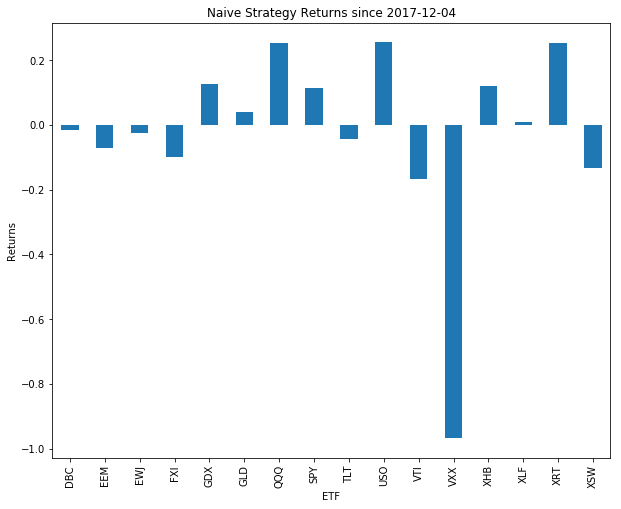

In [22]:
(pd.concat([train_rsi, test_rsi]).sum() / start).plot(figsize=(10, 8), kind='bar')
plt.title('Naive Strategy Returns since 2017-12-04')
plt.xlabel('ETF')
plt.ylabel('Returns')
plt.show()

In [25]:
diff

DBC   -0.059186
EEM   -0.096230
EWJ   -0.095250
FXI   -0.126349
GDX    0.038530
GLD    0.042647
QQQ    0.183618
SPY    0.088853
TLT    0.042180
USO   -0.056710
VTI    0.075933
VXX   -0.142697
XHB   -0.070782
XLF   -0.028093
XRT   -0.044068
XSW    0.364588
dtype: float64

In [26]:
# Ideal Strategy: For what assets do we exceed returns?
overall_rsi_ideal.sum() / start > diff

DBC     True
EEM     True
EWJ     True
FXI     True
GDX     True
GLD     True
QQQ     True
SPY     True
TLT    False
USO     True
VTI    False
VXX     True
XHB     True
XLF     True
XRT     True
XSW    False
dtype: bool

In [24]:
# Overall Strategy: For what assets do we exceed returns?
overall_rsi_pred.sum() / start > diff

DBC     True
EEM     True
EWJ     True
FXI    False
GDX    False
GLD    False
QQQ     True
SPY     True
TLT    False
USO     True
VTI    False
VXX     True
XHB     True
XLF     True
XRT     True
XSW    False
dtype: bool

Although we see that our ideal and predicted strategies outperform most ETFs in our universe, we need to perform statistical tests to ensure the means of these distributions are truly different. We will test weekly returns for each strategy.

In [165]:
bh_returns = tick[['close_' + s for s in symbols]].loc['2017-12-04':].between_time('09:30:00','09:30:01').resample('W').first()

In [166]:
bh_returns = bh_returns.dropna().pct_change().dropna()
bh_returns.columns = symbols

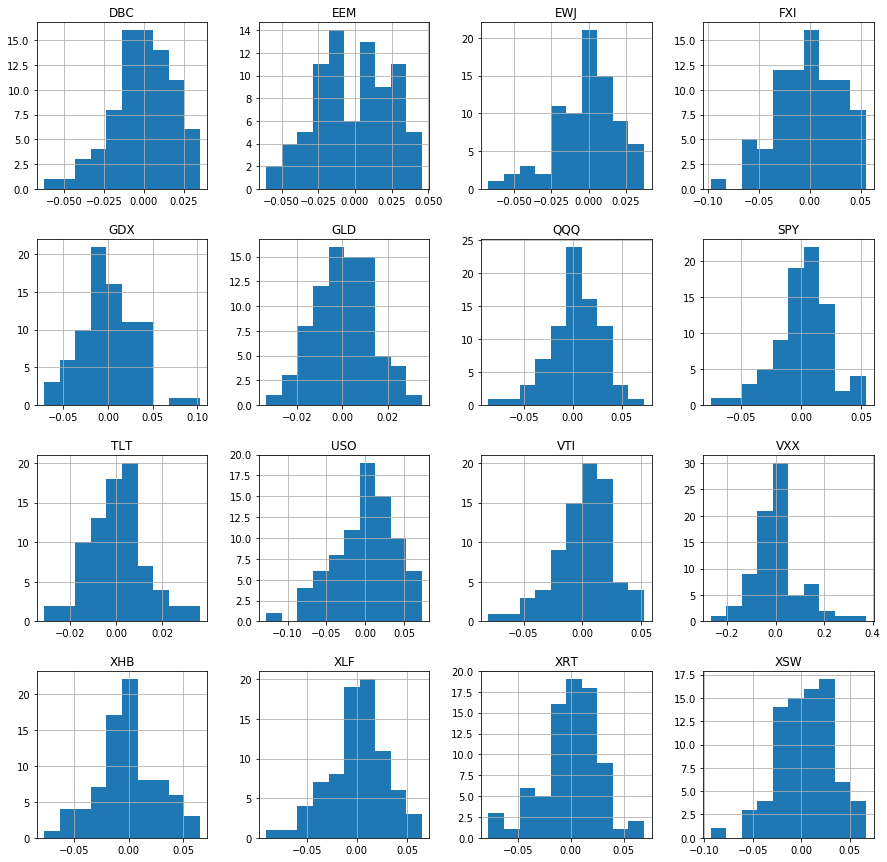

In [167]:
# Observe buy and hold returns
bh_returns.hist(figsize=(15, 15))
plt.show()

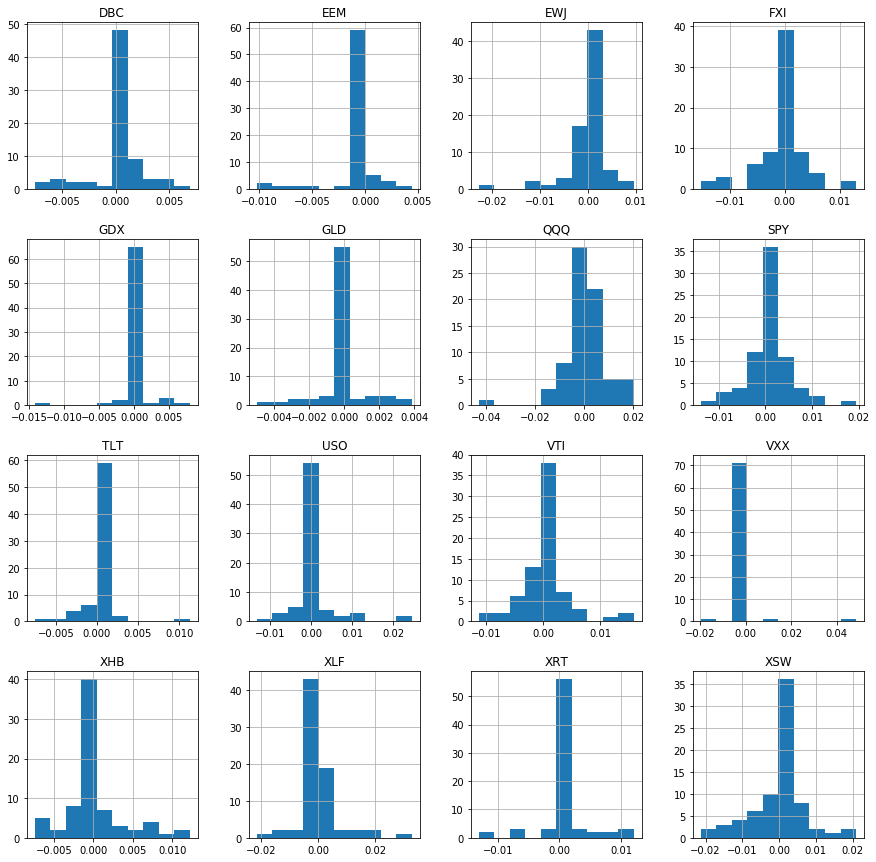

In [169]:
# Returns of our strategy
strat_returns = (overall_rsi_pred / start).resample('W').first().dropna()
strat_returns.hist(figsize=(15, 15))
plt.show()

In [185]:
strat_returns.mean() > bh_returns.mean()

DBC     True
EEM     True
EWJ     True
FXI     True
GDX    False
GLD    False
QQQ    False
SPY    False
TLT    False
USO     True
VTI    False
VXX    False
XHB     True
XLF     True
XRT     True
XSW    False
dtype: bool

In [170]:
from scipy import stats

def get_ttest(strat_returns, bh_returns=bh_returns, symbols=symbols):
    """ Gets a two sample ttest to determine if our daily strategy returns are greater than buy and hold returns on average. """
    # Keep track of ETFs where our strategy has an advantage
    adv_etfs = []
    for symbol in symbols:
        # Get two-sample ttest
        results = stats.ttest_ind(strat_returns[symbol], bh_returns[symbol], equal_var=False)

        # pvalue <<< 0.10 reject null hypothesis, mean of strategy returns better than 
        alpha = 0.10
        if (results[0] > 0) & (results[1]/2 < alpha):
            #adv_etfs.append(symbol)
            print(f"Reject null hypothesis, mean weekly return of strategy for {symbol} is greater than mean weekly return of buy and hold")
        else:
            print(f"Accept null hypothesis, difference in weekly return mean for {symbol} is not statistically significant")
    return adv_etfs


In [171]:
# Test predicted strategy
adv_etfs = get_ttest(strat_returns)

Accept null hypothesis, difference in weekly return mean for DBC is not statistically significant
Accept null hypothesis, difference in weekly return mean for EEM is not statistically significant
Accept null hypothesis, difference in weekly return mean for EWJ is not statistically significant
Accept null hypothesis, difference in weekly return mean for FXI is not statistically significant
Accept null hypothesis, difference in weekly return mean for GDX is not statistically significant
Accept null hypothesis, difference in weekly return mean for GLD is not statistically significant
Accept null hypothesis, difference in weekly return mean for QQQ is not statistically significant
Accept null hypothesis, difference in weekly return mean for SPY is not statistically significant
Accept null hypothesis, difference in weekly return mean for TLT is not statistically significant
Accept null hypothesis, difference in weekly return mean for USO is not statistically significant
Accept null hypothes

# Conclusion & Next Steps

Our Model performs better than the naive strategy over the course of usable data going back to 2018. Additionally, on an individual ETF level, our predicted model exceeds buy and hold returns for 10 out of 16 ETFs. The ideal strategy exceeds buy and hold returns for 13/16 ETFs. However, when it came to statistical significance at the 10% confidence level, we did not outperform buy and hold on a weekly scale for any assets using our predicted strategy. This gives insight into how challenging it is to outperform the stock market using algorithmic strategy. It is very difficult to achieve an accuracy higher than 60 for the overall strategy due to the high stochasticity of financial data. Note that since we are backtesting out of fold, this gives us a good sense of how our algorithm would perform in real time. Furthermore, there are many hyperparameters that could be perfected such as: <br>
 - The volatility & volume cutoff point: Right now we are using 50th percentile for each etf.
 - The RSI lookback: Right now we are using 20 minutes for each etf.
 - ETF Universe: We handpicked these ETFs as they are well known for day trading and have high overall volume. Clearly, certain ones such as VTI do not perform very well with this strategy. If we tested more ETFs, we could likely find some where this strategy outperforms buy and hold.
 - Portfolio optimization: How much to allocate to each ETF? Right now we are evenly distributing
 - Stop loss and profit take: Right now we only exit trades according to an RSI reversal or at end of day. This is definitely suboptimal in the long run, so we would need to add stop loss and profit take for each.
 - Brokerage Fees and Slippage: This backtest assumes that each trade would've been perfectly executed without any fees. This is highly idealistic... usually trades are rarely executed exactly at ticker price (this concept is known as slippage). Furthermore, trades are usually executed at a small fee. Our trading API Alpaca allows us to execute feeless trades, however slippage would definitely be an issue.

## Live trading

For live trading, we would need to ensure that our model is up to date. A preliminary protocol would be to retrain weekly, perhaps at the end of the trading day on Friday. Furthermore, we would need to make sure our news and ticker data are up to date. We have written a script which will take care of updating our data automatically, and takes about 6 minutes to do so. We need to make sure to update our news data frequently since through our API, we can only access 100 news articles at a time.

Once live, we would simply execute our model at 10am sharp during the trading day. This means gathering the latest news, fitting our tokenizer and predicting using our NLP network. Furthermore, we would gather ticker data from 8:00am until 10:00am, reshape it, and feed it into our ticker neural network. Once we have our first predictions, we would feed these predictions into our random forest models and achieve our final predictions. Then, we will only trade our RSI strategy on the ETFs we predict will have higher than usual volume and volatility that day.

# Thank you!